<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Mounted at /content/gdrive


In [2]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [3]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

37997/37997 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step
        Feature  Mutual_Info  RF_Importance  AE_Recon_Error  Rank_MI  Rank_RF  \
44        Label     0.805673   1.872171e-01        2.721094      1.0      2.0   
45  Attack Tool     0.734534   2.830836e-01        1.975076      2.0      1.0   
0    Unnamed: 0     0.634591   7.332812e-02        2.599107      3.0      4.0   
12        sHops     0.196922   2.024697e-02        0.743636     10.0      8.0   
66          tcp     0.167434   1.566035e-02        0.815803     11.0     11.0   
..          ...          ...            ...             ...      ...      ...   
91          cs6     0.003348   1.838256e-11        0.072249     69.0     83.0   
86         af11     0.003845   0.000000e+00        0.050394     67.0     90.0   
64         lldp     0.002201   0.000000e+00        0.085157     75.0     90.0   
37         sVid     0.000059   0.000000e+00        0.009159     92.0     90.0   
38         dVid     0.000000   0.000000e+00        0.008092    

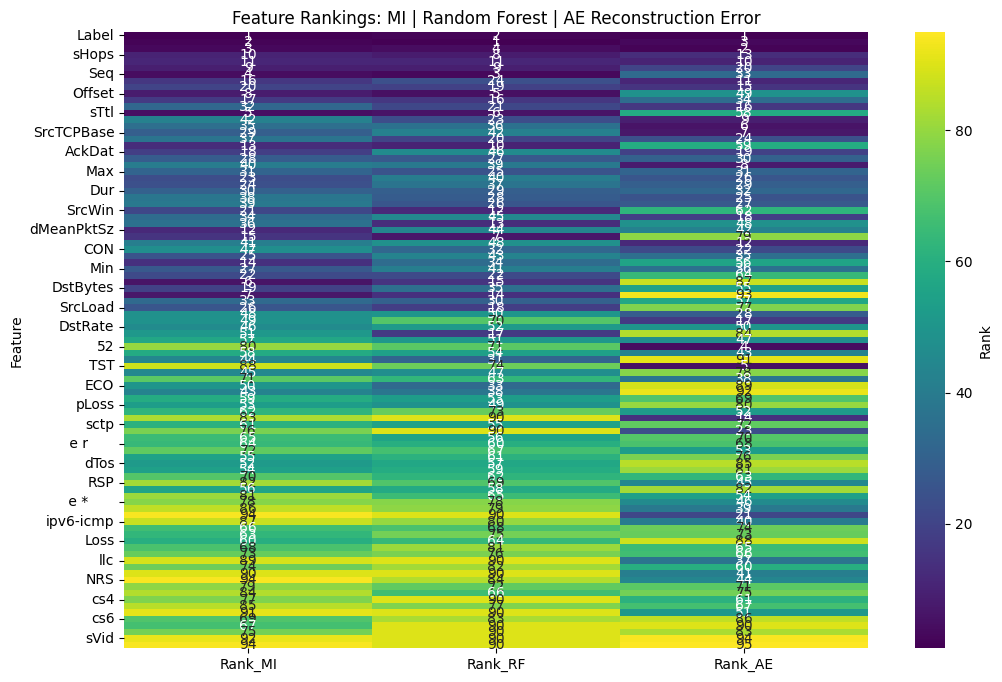

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# 1. Preparar dataset
# =====================
df = encoded
df_features = df.drop(columns=['Attack Type']).copy()
features = df_features.columns.tolist()

# Converter colunas categóricas para numéricas
for col in df_features.columns:
    if df_features[col].dtype == 'object':
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col])

X = df_features.values
y = df['Attack Type'].values
y_bin = (y != 'Benign').astype(int)  # 0=Benigno, 1=Ataque

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =====================
# 2. Mutual Information
# =====================
mi = mutual_info_classif(X_scaled, y_bin, discrete_features=False)
mi_df = pd.DataFrame({'Feature': features, 'Mutual_Info': mi})

# =====================
# 3. Random Forest Importance
# =====================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_bin)
rf_importances = rf.feature_importances_
rf_df = pd.DataFrame({'Feature': features, 'RF_Importance': rf_importances})

# =====================
# 4. Autoencoder Reconstruction Error
# =====================
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(encoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    ae = models.Model(inputs=input_layer, outputs=output_layer)
    ae.compile(optimizer='adam', loss='mse')
    return ae

ae = build_autoencoder(X_scaled.shape[1])
ae.fit(X_scaled[y_bin==0], X_scaled[y_bin==0], epochs=20, batch_size=128, shuffle=True, verbose=0)
X_pred = ae.predict(X_scaled)
recon_error = np.mean((X_scaled - X_pred)**2, axis=0)
ae_df = pd.DataFrame({'Feature': features, 'AE_Recon_Error': recon_error})

# =====================
# 5. Consolidar tabelas
# =====================
consolidated = mi_df.merge(rf_df, on='Feature').merge(ae_df, on='Feature')

# Calcular rank individual e médio
consolidated['Rank_MI'] = consolidated['Mutual_Info'].rank(ascending=False)
consolidated['Rank_RF'] = consolidated['RF_Importance'].rank(ascending=False)
consolidated['Rank_AE'] = consolidated['AE_Recon_Error'].rank(ascending=False)
consolidated['Mean_Rank'] = consolidated[['Rank_MI','Rank_RF','Rank_AE']].mean(axis=1)

# Ordenar pelo Rank médio
consolidated = consolidated.sort_values(by='Mean_Rank', ascending=True)

# =====================
# 6. Mostrar e salvar
# =====================
pd.set_option('display.max_columns', None)
print(consolidated)

consolidated.to_csv("feature_correlation_ranking.csv", index=False)

# =====================
# 7. Heatmap de rankings
# =====================
plt.figure(figsize=(12,8))
sns.heatmap(consolidated[['Rank_MI','Rank_RF','Rank_AE']].set_index(consolidated['Feature']),
            annot=True, cmap='viridis', cbar_kws={'label':'Rank'})
plt.title("Feature Rankings: MI | Random Forest | AE Reconstruction Error")
plt.show()